In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

True
1
0
NVIDIA GeForce RTX 3090


'dx' is short for diagnosis (for the patient)
- 'nv': 'Melanocytic nevi'
- 'mel': 'Melanoma'
- 'bkl': 'Benign keratosis-like lesions'
- 'bcc': 'Basal cell carcinoma'
- 'akiec': 'Actinic keratoses'
- 'vasc': 'Vascular lesions'
- 'df': 'Dermatofibroma'

'dx_type' is how the diagnosis was made. 
- histo        5340
- follow_up    3704
- consensus     902
- confocal       69

In [2]:
## Now, we import timm, torchvision image models
!pip install timm # kaggle doesnt have it installed by default
import timm
from timm.loss import LabelSmoothingCrossEntropy # This is better than normal nn.CrossEntropyLoss

In [3]:
import pandas as pd
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

def disease_to_label(l):
    if l == "akiec":
        return 0
    if l == "bcc":
        return 1
    if l == "bkl":
        return 2
    if l == "df":
        return 3
    if l == "mel":
        return 4
    if l == "nv":
        return 5
    if l == "vasc":
        return 6 

class SkinCancerDetection_train(Dataset):
    
    def __init__(self, train_path, csv, transform=None):
        self.train_path = train_path
        self.csv_path = csv
        self.transform = transform
    def __len__(self):
        df = pd.read_csv(self.csv_path)
        return (len(df.index))
    def __getitem__(self, idx):
        image_id = "ISIC_00" + str(idx+25306)
        image_file_name = image_id + ".jpg"
        df = pd.read_csv(self.csv_path)
        label = disease_to_label(str(df.loc[df['image_id'] == image_id, 'dx'].item()))
        p = os.path.join(self.train_path, image_file_name)

        img = plt.imread(p)


        if self.transform:
            img = self.transform(img)
        
        return img, label
    
class SkinCancerDetection_test(Dataset):
    
    def __init__(self, test_path, csv, transform=None):
        self.test_path = test_path
        self.csv_path = csv
        self.transform = transform
    def __len__(self):
        df = pd.read_csv(self.csv_path)
        return (len(df.index))
    def __getitem__(self, idx):
        image_id = "ISIC_00" + str(idx+24306)
        image_file_name = image_id + ".jpg"
        df = pd.read_csv(self.csv_path)
        label = disease_to_label(str(df.loc[df['image_id'] == image_id, 'dx'].item()))
        
        p = os.path.join(self.test_path, image_file_name)
        
        img = plt.imread(p)
            
        if self.transform:
            img = self.transform(img)
        
        return img, label

In [4]:
train_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter()]), p=0.25),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD), # imagenet means
            transforms.RandomErasing(p=0.1, value='random')
        ])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD) # imagenet means
])

train_ds = SkinCancerDetection_train('../../kaggle/input/HAM10000_images_train_9000','../../kaggle/input/HAM10000_metadata_train_9000.csv',transform=train_transform)
val_ds = SkinCancerDetection_test('../../kaggle/input/HAM10000_images_test_1000','../../kaggle/input/HAM10000_metadata_test_1000.csv',transform=test_transform)

In [5]:
len(val_ds)

1000

## Split train and validation dataset
- batch_size = 128 (train_dl=128; valid_dl=256)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>


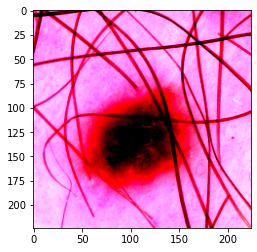

tensor(5)


In [6]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torch.utils.data import DataLoader

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

random_seed = 42
torch.manual_seed(random_seed)

# batch_size = 128
batch_size = 64 

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

plt.figure()

for image, label in train_dl:
    plt.imshow(image[0].permute(2, 1, 0))
    print(type(image[0]))
    plt.show()
    print(label[0])
    break

In [7]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [8]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


In [9]:
HUB_URL = "SharanSMenon/swin-transformer-hub:main"
MODEL_NAME = "swin_tiny_patch4_window7_224"
# check hubconf for more models.
swin_tiny_patch4_window7_224 = torch.hub.load(HUB_URL, MODEL_NAME, pretrained=True) # load from torch hub

Using cache found in /home/jujie/.cache/torch/hub/SharanSMenon_swin-transformer-hub_main
/home/jujie/anaconda3/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [10]:
model = to_device(swin_tiny_patch4_window7_224, device)
model

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): BasicLayer(
      dim=96, input_resolution=(56, 56), depth=2
      (blocks): ModuleList(
        (0): SwinTransformerBlock(
          dim=96, input_resolution=(56, 56), num_heads=3, window_size=7, shift_size=0, mlp_ratio=4.0
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            dim=96, window_size=(7, 7), num_heads=3
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNo

In [11]:
from sklearn.metrics import precision_recall_fscore_support

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def training_step(criterion, model,batch):
    images, labels = batch 
    out = model(images)                  # Generate predictions
    loss = criterion(out, labels)  # criterion is already to device GPU
    return loss

def validation_step(criterion, model,batch):
    images, labels = batch 
    out = model(images)                    # Generate predictions
    loss = criterion(out, labels)   # Calculate loss
    
#     ---------------- why here acc not to(device)
    acc = accuracy(out, labels)           # Calculate accuracy (return a tensor)
    
#     ------------------- calculate fscore for each batch ----------------
    _, y_preds = torch.max(out, dim=1)    
    threeMetrics = precision_recall_fscore_support(torch.Tensor.cpu(labels), torch.Tensor.cpu(y_preds), average=None,labels=[i for i in range(7)])
    fscore = torch.tensor(threeMetrics[2]) # fscore (return a tensor of a list: tensor([1,2,3]))
    
    return {'val_loss': loss.detach(), 'val_acc': acc, 'val_fscore': fscore}
    
def validation_epoch_end(outputs):
    batch_losses = [x['val_loss'] for x in outputs] 
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses (mean loss for n batches)
    
    batch_accs = [x['val_acc'] for x in outputs]   # [ each element is a tensor ]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies (mean acc for n batches)
    
    batch_fscores = [x['val_fscore'] for x in outputs] 
    epoch_fscore = torch.stack(batch_fscores).mean(0)
    
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item(), 'val_fscore': epoch_fscore.tolist()}

def epoch_end(epoch, result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}, val_fscore: {} ".format(
        epoch, result['train_loss'], result['val_loss'], result['val_acc'], result['val_fscore']))

In [12]:
criterion = LabelSmoothingCrossEntropy(smoothing=0.1)
criterion = criterion.to(device)
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.05)

In [13]:
@torch.no_grad()
def evaluate(criterion, model, val_loader):
    model.eval()
    outputs = [validation_step(criterion, model, batch) for batch in val_loader]
    return validation_epoch_end(outputs)

def fit_one_cycle(num_epochs, model, train_loader, val_loader, optimizer, criterion):
    torch.cuda.empty_cache()
    history = []
  


    # sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=5e-6, last_epoch=- 1, verbose=False)
    
    for epoch in range(num_epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = training_step(criterion,model,batch)
            train_losses.append(loss)
            loss.backward()
            
#             # Gradient clipping
#             if grad_clip: 
#                 nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
        # Validation phase
        result = evaluate(criterion, model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        epoch_end(epoch, result)
        history.append(result)
    return history

In [14]:
# remove warnings
import warnings
warnings.filterwarnings("ignore")

In [15]:
history = [evaluate(criterion, model, valid_dl)]
history

[{'val_loss': 6.018776893615723,
  'val_acc': 0.008037860505282879,
  'val_fscore': [0.0, 0.0, 0.0, 0.0, 0.0, 0.022915805634593882, 0.0]}]

In [16]:
num_epochs=4
history += fit_one_cycle(num_epochs, model, train_dl, valid_dl, optimizer, criterion)

Epoch [0], train_loss: 1.9932, val_loss: 1.7090, val_acc: 0.7212, val_fscore: [0.0, 0.0, 0.40546120546120545, 0.0, 0.125, 0.8519531186423686, 0.0] 
Epoch [1], train_loss: 1.7809, val_loss: 1.7068, val_acc: 0.7271, val_fscore: [0.09642857142857145, 0.3676767676767677, 0.42368400989428034, 0.0, 0.39846951435661115, 0.8723854507089229, 0.0] 
Epoch [2], train_loss: 1.6943, val_loss: 1.6291, val_acc: 0.7714, val_fscore: [0.4264159451659452, 0.6181818181818182, 0.4951789483696917, 0.0, 0.15326266870384517, 0.8881299397212172, 0.0] 
Epoch [3], train_loss: 1.6480, val_loss: 1.5797, val_acc: 0.7714, val_fscore: [0.18392857142857144, 0.5863607883344726, 0.4792995746943115, 0.0, 0.3713612943270367, 0.8799580220363352, 0.16666666666666666] 


In [23]:
num_epochs=4
history += fit_one_cycle(num_epochs, model, train_dl, valid_dl, optimizer, criterion)

Epoch [0], train_loss: 1.5966, val_loss: 1.5279, val_acc: 0.7920, val_fscore: [0.41986832611832614, 0.5947838345864662, 0.5498793768955059, 0.0, 0.49197989510489504, 0.9083892768620327, 0.5166666666666666] 
Epoch [1], train_loss: 1.5516, val_loss: 1.5518, val_acc: 0.7909, val_fscore: [0.23194444444444445, 0.6687770562770563, 0.541719887464102, 0.21666666666666667, 0.08269230769230769, 0.8995371974728011, 0.6416666666666666] 
Epoch [2], train_loss: 1.5229, val_loss: 1.5069, val_acc: 0.7936, val_fscore: [0.35000000000000003, 0.6787448662448662, 0.5458188819744884, 0.08333333333333333, 0.2210196666079019, 0.9015351757256048, 0.6821428571428572] 
Epoch [3], train_loss: 1.5055, val_loss: 1.5238, val_acc: 0.8029, val_fscore: [0.45211038961038963, 0.4797008547008547, 0.5928684771083226, 0.0, 0.3865744087783562, 0.8990627646888427, 0.6583333333333333] 


In [24]:
num_epochs=4
history += fit_one_cycle(num_epochs, model, train_dl, valid_dl, optimizer, criterion)

Epoch [0], train_loss: 1.4892, val_loss: 1.4329, val_acc: 0.8229, val_fscore: [0.5369047619047619, 0.7040334665334664, 0.5884721169634963, 0.44047619047619047, 0.4763034067381894, 0.9199782930559192, 0.6666666666666666] 
Epoch [1], train_loss: 1.4493, val_loss: 1.4865, val_acc: 0.8185, val_fscore: [0.2755952380952381, 0.696199552081905, 0.5471780695150261, 0.5863095238095237, 0.5261695316333608, 0.9200998200148296, 0.6875] 
Epoch [2], train_loss: 1.4636, val_loss: 1.4506, val_acc: 0.8260, val_fscore: [0.37678571428571433, 0.7357637620265497, 0.6402000712565727, 0.31547619047619047, 0.26194718271924156, 0.9226962352117398, 0.725] 
Epoch [3], train_loss: 1.4219, val_loss: 1.4980, val_acc: 0.8043, val_fscore: [0.17500000000000004, 0.6994365928189458, 0.43475218710672675, 0.29166666666666663, 0.41479786422578185, 0.9106354224783724, 0.7208333333333333] 


In [25]:
num_epochs=4
history += fit_one_cycle(num_epochs, model, train_dl, valid_dl, optimizer, criterion)

Epoch [0], train_loss: 1.4072, val_loss: 1.4555, val_acc: 0.8093, val_fscore: [0.12142857142857144, 0.6946969696969697, 0.6209588928584138, 0.44791666666666663, 0.5512418178366454, 0.9162722747307509, 0.6833333333333333] 
Epoch [1], train_loss: 1.3884, val_loss: 1.4343, val_acc: 0.8492, val_fscore: [0.35925324675324677, 0.7010599055675784, 0.6877909836970629, 0.31547619047619047, 0.633298060146608, 0.9312014212897701, 0.6583333333333333] 
Epoch [2], train_loss: 1.3751, val_loss: 1.5193, val_acc: 0.8080, val_fscore: [0.46249999999999997, 0.6741341991341991, 0.5447426842163684, 0.2738095238095238, 0.2620360644257703, 0.9052975750134501, 0.6666666666666666] 
Epoch [3], train_loss: 1.3691, val_loss: 1.5065, val_acc: 0.8056, val_fscore: [0.39355158730158735, 0.4557720057720058, 0.6121714249712751, 0.3694444444444444, 0.4628755503755504, 0.9160723335338048, 0.6875] 


In [26]:
num_epochs=2
history += fit_one_cycle(num_epochs, model, train_dl, valid_dl, optimizer, criterion)

Epoch [0], train_loss: 1.3535, val_loss: 1.4244, val_acc: 0.8276, val_fscore: [0.4912927350427351, 0.6919817927170869, 0.6173028987957002, 0.31547619047619047, 0.42527188359568224, 0.9222567410112417, 0.6416666666666666] 
Epoch [1], train_loss: 1.3429, val_loss: 1.4488, val_acc: 0.8305, val_fscore: [0.29972943722943723, 0.7397528077376476, 0.6220195814529431, 0.175, 0.4520467277820219, 0.9181857039906678, 0.6125] 


In [27]:
num_epochs=2
history += fit_one_cycle(num_epochs, model, train_dl, valid_dl, optimizer, criterion)

Epoch [0], train_loss: 1.3225, val_loss: 1.4268, val_acc: 0.8321, val_fscore: [0.478968253968254, 0.6983088558216436, 0.6547764205234494, 0.3902777777777777, 0.4458610123891454, 0.9212816331475863, 0.7041666666666666] 
Epoch [1], train_loss: 1.3178, val_loss: 1.4735, val_acc: 0.8212, val_fscore: [0.2785714285714286, 0.645076098365572, 0.5856977789722355, 0.28125, 0.5448757954478778, 0.9222223615282554, 0.6208333333333333] 


In [28]:
# torch.save(model.state_dict(), 'deit_tiny_patch16_224.pth')
torch.save(model.state_dict(), '../../kaggle/ubuntu_save_model/ubuntu_sourceCode_size91_swin_tiny_patch4_window7_224.pth')

In [29]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

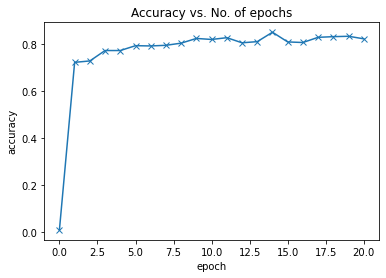

In [30]:
plot_accuracies(history)

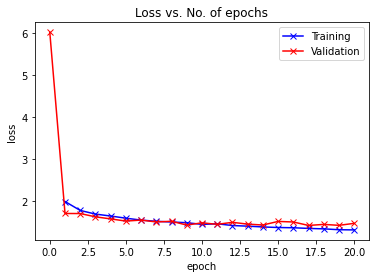

In [31]:
plot_losses(history)